In [1]:
import EITfunc.EITlook as eit

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import matplotlib.cm as cmx
import matplotlib.colorbar as cb
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

import os

from astropy import units as u
from astropy.constants import G
from astropy.io import ascii, fits
from astropy.table import Table
from astropy.timeseries import LombScargle
import astropy.time
from astropy.coordinates import HeliocentricMeanEcliptic, HeliocentricTrueEcliptic, SkyCoord

from astropy.coordinates import solar_system_ephemeris, EarthLocation
from astropy.coordinates import get_body_barycentric, get_body

import sunpy.coordinates

import scipy.optimize as sciop
from scipy.stats import mode, binned_statistic
import scipy.signal 

import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
EITmetadata = Table.read("./EIT/EITresults/EIT_headerMetadata.txt",format="ascii.basic")
print(np.shape(EITmetadata))
print(EITmetadata)
print(EITmetadata.colnames)

(91883,)
     DATE-BEG           DATE-AVG      XPOSURE CMDXPOS SHUTCLS FILTER ... SC_X0 SC_Y0 SC_ROLL    HAEX_OBS       HAEY_OBS      HAEZ_OBS 
------------------ ------------------ ------- ------- ------- ------ ... ----- ----- ------- -------------- -------------- -----------
2450098.5366403703  2450098.536677118    6.35    10.0     2.1  Al_+1 ...   0.0   0.0    0.01 -64908808000.0 130562576000.0 -77407740.0
 2450098.509462373 2450098.5129467477   602.1   600.0     2.1 Al_sup ...   0.0   0.0    0.01 -64908808000.0 130562576000.0 -77407740.0
  2450099.07985044  2450099.079920463    12.1    10.0     2.1  Al_+1 ...   0.0   0.0   -0.04 -64908808000.0 130562576000.0 -77407740.0
2450098.5201983913  2450098.520678391  82.944    90.0     2.1 Al_sup ...   0.0   0.0    0.01 -64908808000.0 130562576000.0 -77407740.0
 2450102.401938831 2450102.4025296876   102.1   100.0     2.1  Al_+1 ...   0.0   0.0   -0.01 -71817840000.0 126939368000.0 -67100020.0
2450102.2426729975 2450102.2427430553    12.1 

In [3]:
dcalc = np.sqrt(EITmetadata['HAEX_OBS']**2 + EITmetadata['HAEY_OBS']**2 + EITmetadata['HAEZ_OBS']**2)


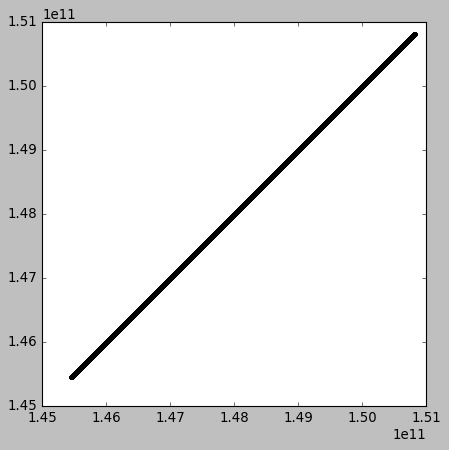

In [4]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.plot(EITmetadata['DSUN_OBS'], dcalc, 'k.')
ax.set_aspect("equal")
plt.show()

In [5]:
for i in range(1):
    HAEcoords = SkyCoord(frame='heliocentricmeanecliptic',
                         x=EITmetadata['HAEX_OBS'][i]*u.m, 
                         y=EITmetadata['HAEY_OBS'][i]*u.m,
                         z=EITmetadata['HAEZ_OBS'][i]*u.m, 
                         representation_type='cartesian',
                         obstime=astropy.time.Time(EITmetadata['DATE-AVG'][i],format='jd'),
                         equinox=astropy.time.Time(EITmetadata['DATE-AVG'][i],format='jd'))
                         #equinox='J2000')
    print(HAEcoords)
    HIcoords = HAEcoords.transform_to(sunpy.coordinates.frames.HeliocentricInertial())
    print(HIcoords)
    HTEcoords = HAEcoords.transform_to(HeliocentricTrueEcliptic(equinox=astropy.time.Time(EITmetadata['DATE-AVG'][i],format='jd')))
    print(HTEcoords)



<SkyCoord (HeliocentricMeanEcliptic: equinox=2450098.536677118, obstime=2450098.536677118): (x, y, z) in m
    (-6.4908808e+10, 1.30562576e+11, -77407740.)>
<SkyCoord (HeliocentricInertial: obstime=2450098.536677118): (lon, lat, distance) in (deg, deg, m)
    (40.49344787, -4.75368571, 1.45807221e+11)>
<SkyCoord (HeliocentricTrueEcliptic: equinox=2450098.536677118, obstime=2450098.536677118): (lon, lat, distance) in (deg, deg, m)
    (116.43616581, -0.03041781, 1.45807221e+11)>


In [6]:
HAEcoords = SkyCoord(frame='heliocentricmeanecliptic',
                     x=EITmetadata['HAEX_OBS']*u.m, 
                     y=EITmetadata['HAEY_OBS']*u.m,
                     z=EITmetadata['HAEZ_OBS']*u.m, 
                     representation_type='cartesian',
                     obstime=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'),
                     equinox=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'))
                     #equinox='J2000')
print(HAEcoords)
HIcoords = HAEcoords.transform_to(sunpy.coordinates.frames.HeliocentricInertial())
print(HIcoords)
HTEcoords = HAEcoords.transform_to(HeliocentricTrueEcliptic(equinox=astropy.time.Time(EITmetadata['DATE-AVG'][i],format='jd'))).cartesian
print(HTEcoords)

<SkyCoord (HeliocentricMeanEcliptic: equinox=[2450098.53667712 2450098.51294675 2450099.07992046 ... 2459945.04670441
 2459944.55117249 2459944.55538405], obstime=[2450098.53667712 2450098.51294675 2450099.07992046 ... 2459945.04670441
 2459944.55117249 2459944.55538405]): (x, y, z) in m
    [(-6.4908808e+10, 1.30562576e+11, -77407740.),
     (-6.4908808e+10, 1.30562576e+11, -77407740.),
     (-6.4908808e+10, 1.30562576e+11, -77407740.), ...,
     (-2.3997426e+10, 1.43888768e+11,  87906600.),
     (-2.2729508e+10, 1.44096144e+11,  88275190.),
     (-2.2747128e+10, 1.44093344e+11,  88270380.)]>
<SkyCoord (HeliocentricInertial: obstime=[2450098.53667712 2450098.51294675 2450099.07992046 ... 2459945.04670441
 2459944.55117249 2459944.55538405]): (lon, lat, distance) in (deg, deg, m)
    [(40.49344787, -4.75368571, 1.45807221e+11),
     (40.49344878, -4.75368579, 1.45807221e+11),
     (40.4934271 , -4.75368388, 1.45807221e+11), ...,
     (23.21800666, -2.83997871, 1.45876186e+11),
     (22

In [7]:
#sunpy ephemeris
earthHAEcoords_ = sunpy.coordinates.ephemeris.get_earth(time=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'),include_velocity=False)
earthHIcoords = earthHAEcoords_.transform_to(sunpy.coordinates.frames.HeliocentricInertial())
#earthHAEcoords = earthHAEcoords_.transform_to(HeliocentricMeanEcliptic(equinox='J2000')).cartesian
earthHAEcoords = earthHAEcoords_.transform_to(HeliocentricMeanEcliptic(equinox=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'))).cartesian
earthHTEcoords = earthHAEcoords_.transform_to(HeliocentricTrueEcliptic(equinox=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'))).cartesian
print(type(earthHTEcoords))
print(earthHTEcoords.x.to(u.m))

<class 'astropy.coordinates.representation.CartesianRepresentation'>
[-6.25781809e+10 -6.25218754e+10 -6.38641557e+10 ... -2.51091452e+10
 -2.38310120e+10 -2.38418829e+10] m


In [8]:
#astropy ephemeris
earthAstropycoords = get_body('earth', time=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'), ephemeris='de432s')
#earthAstropyHAE = earthAstropycoords.transform_to(HeliocentricTrueEcliptic(equinox='J2000')).cartesian
earthAstropyHAE = earthAstropycoords.transform_to(HeliocentricMeanEcliptic(equinox=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'))).cartesian
earthAstropyHTE = earthAstropycoords.transform_to(HeliocentricTrueEcliptic(equinox=astropy.time.Time(EITmetadata['DATE-AVG'],format='jd'))).cartesian
print(earthAstropycoords)
print(earthAstropyHTE)
print(earthAstropyHTE.x.to(u.m))

<SkyCoord (GCRS: obstime=[2450098.53667712 2450098.51294675 2450099.07992046 ... 2459945.04670441
 2459944.55117249 2459944.55538405], obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, km)
    [(246.44076063, -41.29577445, 2.15347882),
     (246.45465654, -41.3358573 , 2.15213079),
     (246.49101078, -40.44065484, 2.18665594), ...,
     (178.90414417, -44.47722418, 1.63628723),
     (178.68171462, -42.6868952 , 1.64991376),
     (178.68524607, -42.70246869, 1.64977702)]>
[(-62578181.51734998, 1.33181371e+08, -303.36865738),
 (-62521876.07192171, 1.33207549e+08, -301.41181009),
 (-63864156.41522846, 1.32575699e+08, -346.14792195), ...,
 (-25109146.3679969 , 1.44947925e+08,  197.66840776),
 (-23831013.16019493, 1.45165485e+08,  240.64817396),
 (-23841884.12871216, 1.45163683e+08,  240.29002944)] km
[-6.25781815e+10 -6.25218761e+10 -6.38641564e+10 ... -2.51091464e+10
 -2.38310132e+10 -2.38418841e+10] m


In [9]:
print(type(HAEcoords))
print(type(HIcoords))
print(type(HAEcoords.x))
print(type(HIcoords.lat))

<class 'astropy.coordinates.sky_coordinate.SkyCoord'>
<class 'astropy.coordinates.sky_coordinate.SkyCoord'>
<class 'astropy.units.quantity.Quantity'>
<class 'astropy.coordinates.angles.Latitude'>


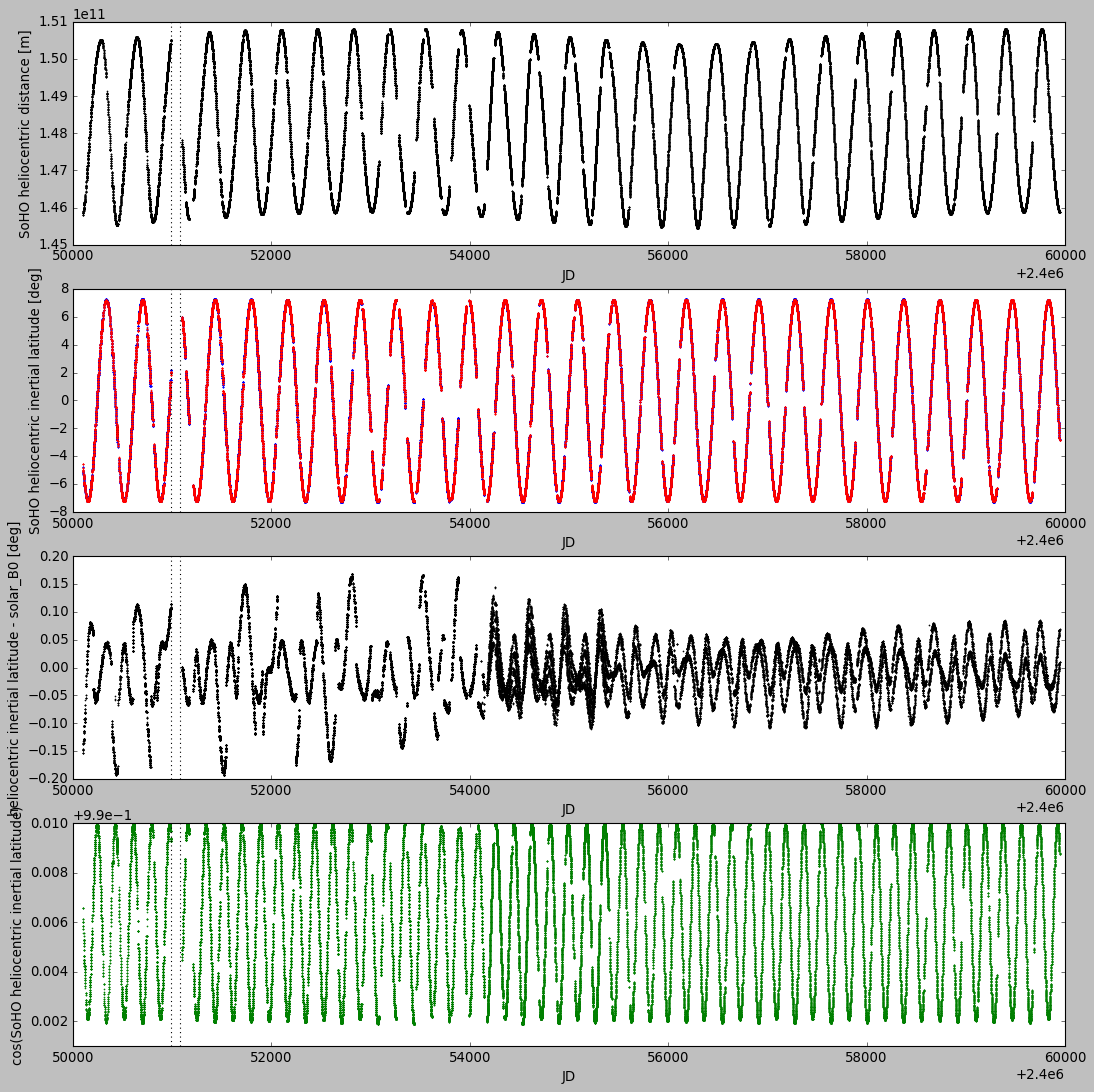

In [10]:
fig, axes = plt.subplots(4,1,figsize=(16,16))

axes[0].plot(EITmetadata['DATE-AVG'], EITmetadata['DSUN_OBS'],'k.',ls='None',ms=2)
axes[0].set_xlabel("JD")
axes[0].set_ylabel("SoHO heliocentric distance [m]")

axes[1].plot(EITmetadata['DATE-AVG'], HIcoords.lat, 'b.',ls='None',ms=2)
axes[1].set_xlabel("JD")
axes[1].set_ylabel("SoHO heliocentric inertial latitude [deg]")
#t = EITmetadata['DATE-AVG'] - EITmetadata['DATE-AVG'][0]
#axes[1].plot(EITmetadata['DATE-AVG'], 7.*np.sin((t/(51.)) + 35),color='r')

axes[1].plot(EITmetadata['DATE-AVG'], EITmetadata['SOLAR_B0'], 'r.',ls='None',ms=2)
#axes[1].set_xlabel("JD")
#axes[1].set_ylabel("SoHO tilt wrt Solar north pole [deg]")
axes[2].plot(EITmetadata['DATE-AVG'], HIcoords.lat.value - EITmetadata['SOLAR_B0'], 'k.',ls='None',ms=2)
axes[2].set_xlabel("JD")
axes[2].set_ylabel("heliocentric inertial latitude - solar_B0 [deg]")

axes[3].plot(EITmetadata['DATE-AVG'], np.cos(HIcoords.lat.to(u.rad)), 'g.',ls='None',ms=2)
axes[3].set_xlabel("JD")
axes[3].set_ylabel("cos(SoHO heliocentric inertial latitude)")


for ax in axes:
    ax.axvline(2450988,color='k',ls=":")
    ax.axvline(2451081,color='k',ls=":")

plt.show()

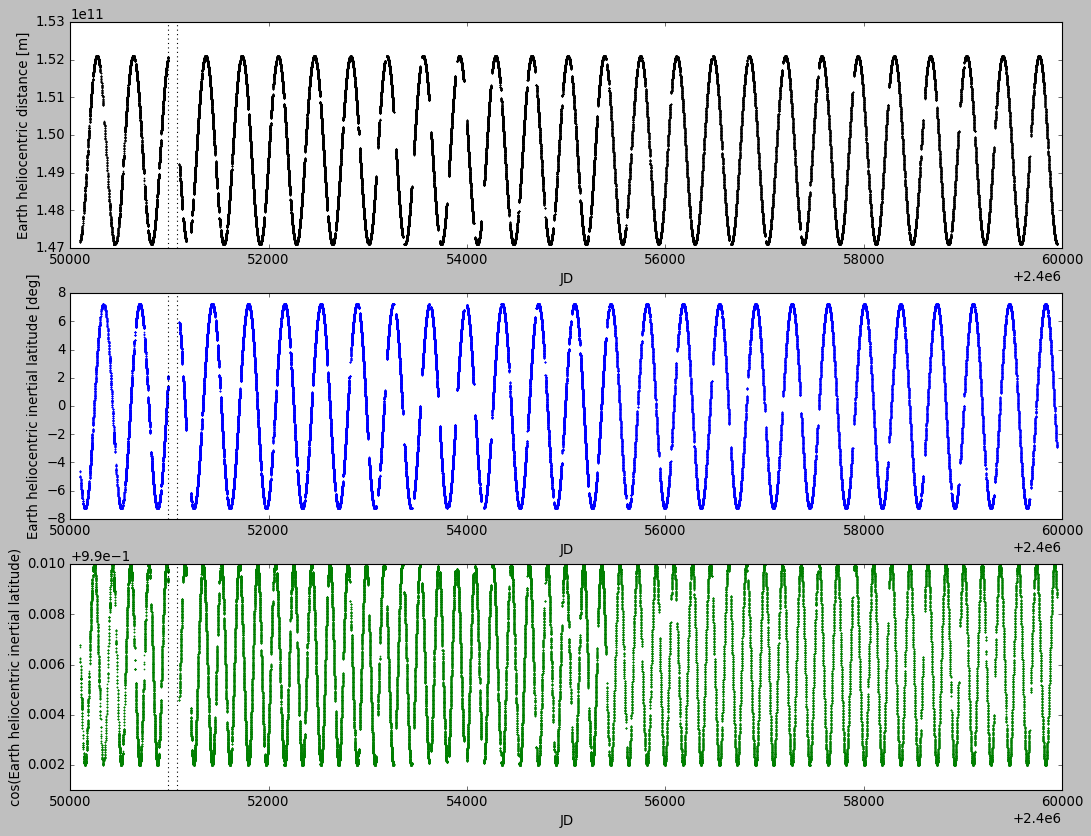

In [11]:
fig, axes = plt.subplots(3,1,figsize=(16,12))

axes[0].plot(EITmetadata['DATE-AVG'], np.sqrt(earthHAEcoords.x.to(u.m)**2 + earthHAEcoords.y.to(u.m)**2 + earthHAEcoords.z.to(u.m)**2),'k.',ls='None',ms=2)
axes[0].set_xlabel("JD")
axes[0].set_ylabel("Earth heliocentric distance [m]")

axes[1].plot(EITmetadata['DATE-AVG'], earthHIcoords.lat, 'b.',ls='None',ms=2)
axes[1].set_xlabel("JD")
axes[1].set_ylabel("Earth heliocentric inertial latitude [deg]")

axes[2].plot(EITmetadata['DATE-AVG'], np.cos(earthHIcoords.lat.to(u.rad)), 'g.',ls='None',ms=2)
axes[2].set_xlabel("JD")
axes[2].set_ylabel("cos(Earth heliocentric inertial latitude)")


for ax in axes:
    ax.axvline(2450988,color='k',ls=":")
    ax.axvline(2451081,color='k',ls=":")

plt.show()

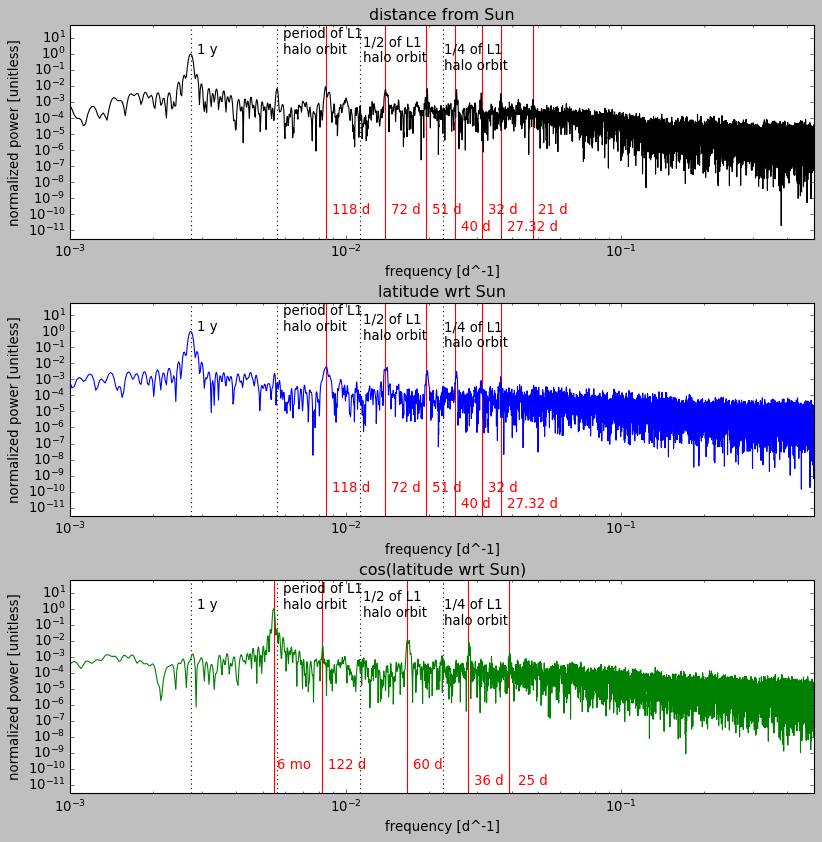

In [12]:
dFreq, dPow = LombScargle(EITmetadata['DATE-AVG'],EITmetadata['DSUN_OBS']).autopower(minimum_frequency=(1./np.ptp(EITmetadata['DATE-AVG'])), maximum_frequency=(1./2.))
lFreq, lPow = LombScargle(EITmetadata['DATE-AVG'],HIcoords.lat).autopower(minimum_frequency=(1./np.ptp(EITmetadata['DATE-AVG'])), maximum_frequency=(1./2.))
coslFreq, coslPow = LombScargle(EITmetadata['DATE-AVG'],np.cos(HIcoords.lat.to(u.rad))).autopower(minimum_frequency=(1./np.ptp(EITmetadata['DATE-AVG'])), maximum_frequency=(1./2.))

fig, axes = plt.subplots(3,1,figsize=(12,12))

axes[0].plot(dFreq,dPow,'k-',zorder=2)
axes[0].set_title("distance from Sun")
axes[1].plot(lFreq,lPow, 'b-',zorder=2)
axes[1].set_title("latitude wrt Sun")
axes[2].plot(coslFreq,coslPow, 'g-',zorder=2)
axes[2].set_title("cos(latitude wrt Sun)")

for ax in axes:
    ax.set_xlabel("frequency [d^-1]")
    ax.set_ylabel("normalized power [unitless]")
    
    #ax.axvline(1./26.24,color='k',ls=':',zorder=1)     #solar rotation
    ax.axvline(1./178., color='k',ls=':',zorder=1)     #period of L1 halo orbit, ~6 months
    ax.axvline(2./178., color='k',ls=':',zorder=1)     #1/2 period of L1 halo orbit, ~3 months
    ax.axvline(4./178., color='k',ls=':',zorder=1)     #1/4 period of L1 halo orbit, ~1.5 months
    ax.axvline(1./365.,color='k',ls=':',zorder=1)      #1 year
    #ax.axvline(3./365.25,color='r')

    #ax.text(1.05/26.24, 1.e0, 'solar'+'\n'+'rotation',fontsize=12)
    ax.text(1.05/178., 1.e0, 'period of L1'+'\n'+'halo orbit',fontsize=12)
    ax.text(1.05/365., 1.e0, '1 y',fontsize=12)
    ax.text(2.05/178., 3.e-1, '1/2 of L1'+'\n'+'halo orbit',fontsize=12,color='k')
    ax.text(4.05/178., 1.e-1, '1/4 of L1'+'\n'+'halo orbit',fontsize=12,color='k')
    #ax.text(1.05/(365*11), 1.e0, 'solar magnetic'+'\n'+'cycle',fontsize=12)
    
    ax.set_xlim(1.e-3,5.e-1)
    ax.set_ylim(3.e-12, 6.e1)
    ax.set_xscale("log")
    ax.set_yscale("log")

for ax in [axes[0]]:
    ax.axvline(1./118.,color='r',zorder=1)
    ax.axvline(1./72.,color='r',zorder=1)
    ax.axvline(1./51.,color='r',zorder=1)
    ax.axvline(1./40.,color='r',zorder=1)
    ax.axvline(1./32.,color='r',zorder=1)
    ax.axvline(1./27.32,color='r',zorder=1)
    ax.axvline(1./21,color='r',zorder=1)
        
    ax.text(1.05/118., 1.e-10, '118 d',fontsize=12,color='r')
    ax.text(1.05/72., 1.e-10, '72 d',fontsize=12,color='r')
    ax.text(1.05/51., 1.e-10, '51 d',fontsize=12,color='r')
    ax.text(1.05/40., 1.e-11, '40 d',fontsize=12,color='r')
    ax.text(1.05/32., 1.e-10, '32 d',fontsize=12,color='r')
    ax.text(1.05/27.32, 1.e-11, '27.32 d',fontsize=12,color='r')
    ax.text(1.05/21., 1.e-10, '21 d',fontsize=12,color='r')

for ax in [axes[1]]:
    ax.axvline(1./118.,color='r',zorder=1)
    ax.axvline(1./72.,color='r',zorder=1)
    ax.axvline(1./51.,color='r',zorder=1)
    ax.axvline(1./40.,color='r',zorder=1)
    ax.axvline(1./32.,color='r',zorder=1)
    ax.axvline(1./27.32,color='r',zorder=1)
    #ax.axvline(1./21,color='r',zorder=1)
        
    ax.text(1.05/118., 1.e-10, '118 d',fontsize=12,color='r')
    ax.text(1.05/72., 1.e-10, '72 d',fontsize=12,color='r')
    ax.text(1.05/51., 1.e-10, '51 d',fontsize=12,color='r')
    ax.text(1.05/40., 1.e-11, '40 d',fontsize=12,color='r')
    ax.text(1.05/32., 1.e-10, '32 d',fontsize=12,color='r')
    ax.text(1.05/27.32, 1.e-11, '27.32 d',fontsize=12,color='r')
    #ax.text(1.05/21., 1.e-10, '21 d',fontsize=12,color='r')

for ax in [axes[2]]:
    ax.axvline(2./365.25,color='r',zorder=1)
    ax.axvline(1./122.,color='r',zorder=1)
    ax.axvline(1./60.,color='r',zorder=1)
    ax.axvline(1./36.,color='r',zorder=1)
    ax.axvline(1./25.5,color='r',zorder=1)
     
    ax.text(2.05/365.25, 1.e-10, '6 mo',fontsize=12,color='r')
    ax.text(1.05/122., 1.e-10, '122 d',fontsize=12,color='r')
    ax.text(1.05/60., 1.e-10, '60 d',fontsize=12,color='r')
    ax.text(1.05/36., 1.e-11, '36 d',fontsize=12,color='r')
    ax.text(1.05/25, 1.e-11, '25 d',fontsize=12,color='r')
   
plt.subplots_adjust(hspace=0.3)
#plt.show()
plt.savefig("SOHOlocationperiodogram.pdf",bbox_inches="tight")

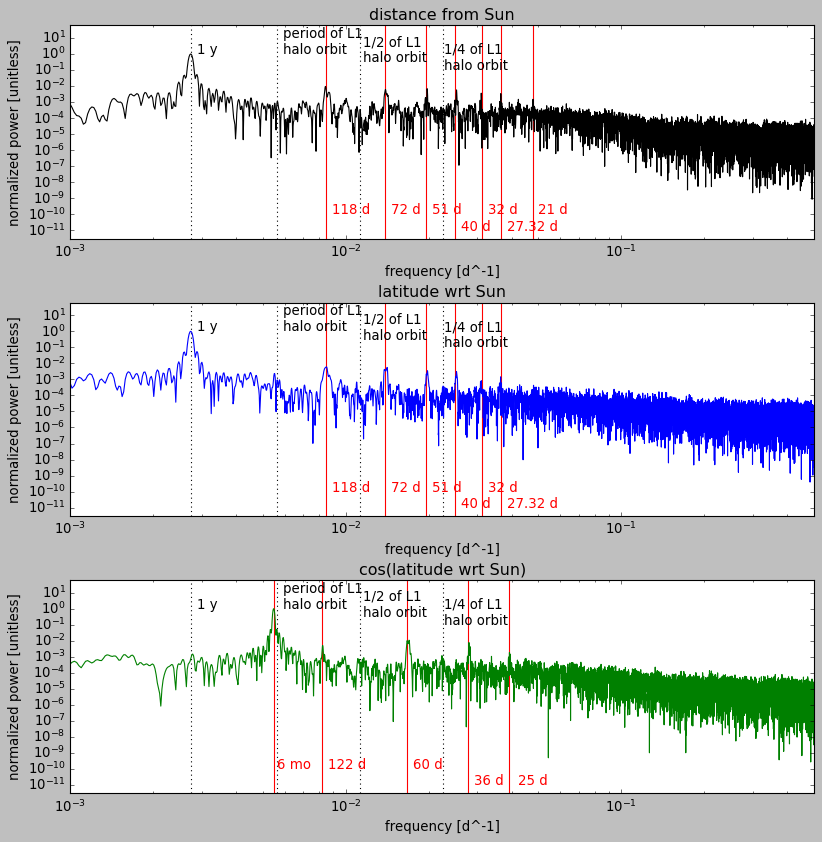

In [13]:
dFreq, dPow = LombScargle(EITmetadata['DATE-AVG'],np.sqrt(earthHAEcoords.x.to(u.m)**2 + earthHAEcoords.y.to(u.m)**2 + earthHAEcoords.z.to(u.m)**2)).autopower(minimum_frequency=(1./np.ptp(EITmetadata['DATE-AVG'])), maximum_frequency=(1./2.))
lFreq, lPow = LombScargle(EITmetadata['DATE-AVG'],earthHIcoords.lat).autopower(minimum_frequency=(1./np.ptp(EITmetadata['DATE-AVG'])), maximum_frequency=(1./2.))
coslFreq, coslPow = LombScargle(EITmetadata['DATE-AVG'],np.cos(earthHIcoords.lat.to(u.rad))).autopower(minimum_frequency=(1./np.ptp(EITmetadata['DATE-AVG'])), maximum_frequency=(1./2.))

fig, axes = plt.subplots(3,1,figsize=(12,12))

axes[0].plot(dFreq,dPow,'k-',zorder=2)
axes[0].set_title("distance from Sun")
axes[1].plot(lFreq,lPow, 'b-',zorder=2)
axes[1].set_title("latitude wrt Sun")
axes[2].plot(coslFreq,coslPow, 'g-',zorder=2)
axes[2].set_title("cos(latitude wrt Sun)")

for ax in axes:
    ax.set_xlabel("frequency [d^-1]")
    ax.set_ylabel("normalized power [unitless]")
    
    #ax.axvline(1./26.24,color='k',ls=':',zorder=1)     #solar rotation
    ax.axvline(1./178., color='k',ls=':',zorder=1)     #period of L1 halo orbit, ~6 months
    ax.axvline(2./178., color='k',ls=':',zorder=1)     #1/2 period of L1 halo orbit, ~3 months
    ax.axvline(4./178., color='k',ls=':',zorder=1)     #1/4 period of L1 halo orbit, ~1.5 months
    ax.axvline(1./365.,color='k',ls=':',zorder=1)      #1 year
    #ax.axvline(3./365.25,color='r')

    #ax.text(1.05/26.24, 1.e0, 'solar'+'\n'+'rotation',fontsize=12)
    ax.text(1.05/178., 1.e0, 'period of L1'+'\n'+'halo orbit',fontsize=12)
    ax.text(1.05/365., 1.e0, '1 y',fontsize=12)
    ax.text(2.05/178., 3.e-1, '1/2 of L1'+'\n'+'halo orbit',fontsize=12,color='k')
    ax.text(4.05/178., 1.e-1, '1/4 of L1'+'\n'+'halo orbit',fontsize=12,color='k')
    #ax.text(1.05/(365*11), 1.e0, 'solar magnetic'+'\n'+'cycle',fontsize=12)
    
    ax.set_xlim(1.e-3,5.e-1)
    ax.set_ylim(3.e-12, 6.e1)
    ax.set_xscale("log")
    ax.set_yscale("log")

for ax in [axes[0]]:
    ax.axvline(1./118.,color='r',zorder=1)
    ax.axvline(1./72.,color='r',zorder=1)
    ax.axvline(1./51.,color='r',zorder=1)
    ax.axvline(1./40.,color='r',zorder=1)
    ax.axvline(1./32.,color='r',zorder=1)
    ax.axvline(1./27.32,color='r',zorder=1)
    ax.axvline(1./21,color='r',zorder=1)
        
    ax.text(1.05/118., 1.e-10, '118 d',fontsize=12,color='r')
    ax.text(1.05/72., 1.e-10, '72 d',fontsize=12,color='r')
    ax.text(1.05/51., 1.e-10, '51 d',fontsize=12,color='r')
    ax.text(1.05/40., 1.e-11, '40 d',fontsize=12,color='r')
    ax.text(1.05/32., 1.e-10, '32 d',fontsize=12,color='r')
    ax.text(1.05/27.32, 1.e-11, '27.32 d',fontsize=12,color='r')
    ax.text(1.05/21., 1.e-10, '21 d',fontsize=12,color='r')

for ax in [axes[1]]:
    ax.axvline(1./118.,color='r',zorder=1)
    ax.axvline(1./72.,color='r',zorder=1)
    ax.axvline(1./51.,color='r',zorder=1)
    ax.axvline(1./40.,color='r',zorder=1)
    ax.axvline(1./32.,color='r',zorder=1)
    ax.axvline(1./27.32,color='r',zorder=1)
    #ax.axvline(1./21,color='r',zorder=1)
        
    ax.text(1.05/118., 1.e-10, '118 d',fontsize=12,color='r')
    ax.text(1.05/72., 1.e-10, '72 d',fontsize=12,color='r')
    ax.text(1.05/51., 1.e-10, '51 d',fontsize=12,color='r')
    ax.text(1.05/40., 1.e-11, '40 d',fontsize=12,color='r')
    ax.text(1.05/32., 1.e-10, '32 d',fontsize=12,color='r')
    ax.text(1.05/27.32, 1.e-11, '27.32 d',fontsize=12,color='r')
    #ax.text(1.05/21., 1.e-10, '21 d',fontsize=12,color='r')

for ax in [axes[2]]:
    ax.axvline(2./365.25,color='r',zorder=1)
    ax.axvline(1./122.,color='r',zorder=1)
    ax.axvline(1./60.,color='r',zorder=1)
    ax.axvline(1./36.,color='r',zorder=1)
    ax.axvline(1./25.5,color='r',zorder=1)
     
    ax.text(2.05/365.25, 1.e-10, '6 mo',fontsize=12,color='r')
    ax.text(1.05/122., 1.e-10, '122 d',fontsize=12,color='r')
    ax.text(1.05/60., 1.e-10, '60 d',fontsize=12,color='r')
    ax.text(1.05/36., 1.e-11, '36 d',fontsize=12,color='r')
    ax.text(1.05/25, 1.e-11, '25 d',fontsize=12,color='r')
   
plt.subplots_adjust(hspace=0.3)
#plt.show()
plt.savefig("Earthlocationperiodogram.pdf",bbox_inches="tight")

In [14]:
jan1_1996 = '1996-01-01T00:00:00.000Z'
jan1_1996 = astropy.time.Time(jan1_1996).jd
print(jan1_1996)

jan1_1997 = '1997-01-01T00:00:00.000Z'
jan1_1997 = astropy.time.Time(jan1_1997).jd
print(jan1_1997)


jan1_1999 = '1999-01-01T00:00:00.000Z'
jan1_1999 = astropy.time.Time(jan1_1999).jd
print(jan1_1999)

jan1_2001 = '2001-01-01T00:00:00.000Z'
jan1_2001 = astropy.time.Time(jan1_2001).jd
print(jan1_2001)

2450083.5
2450449.5
2451179.5
2451910.5


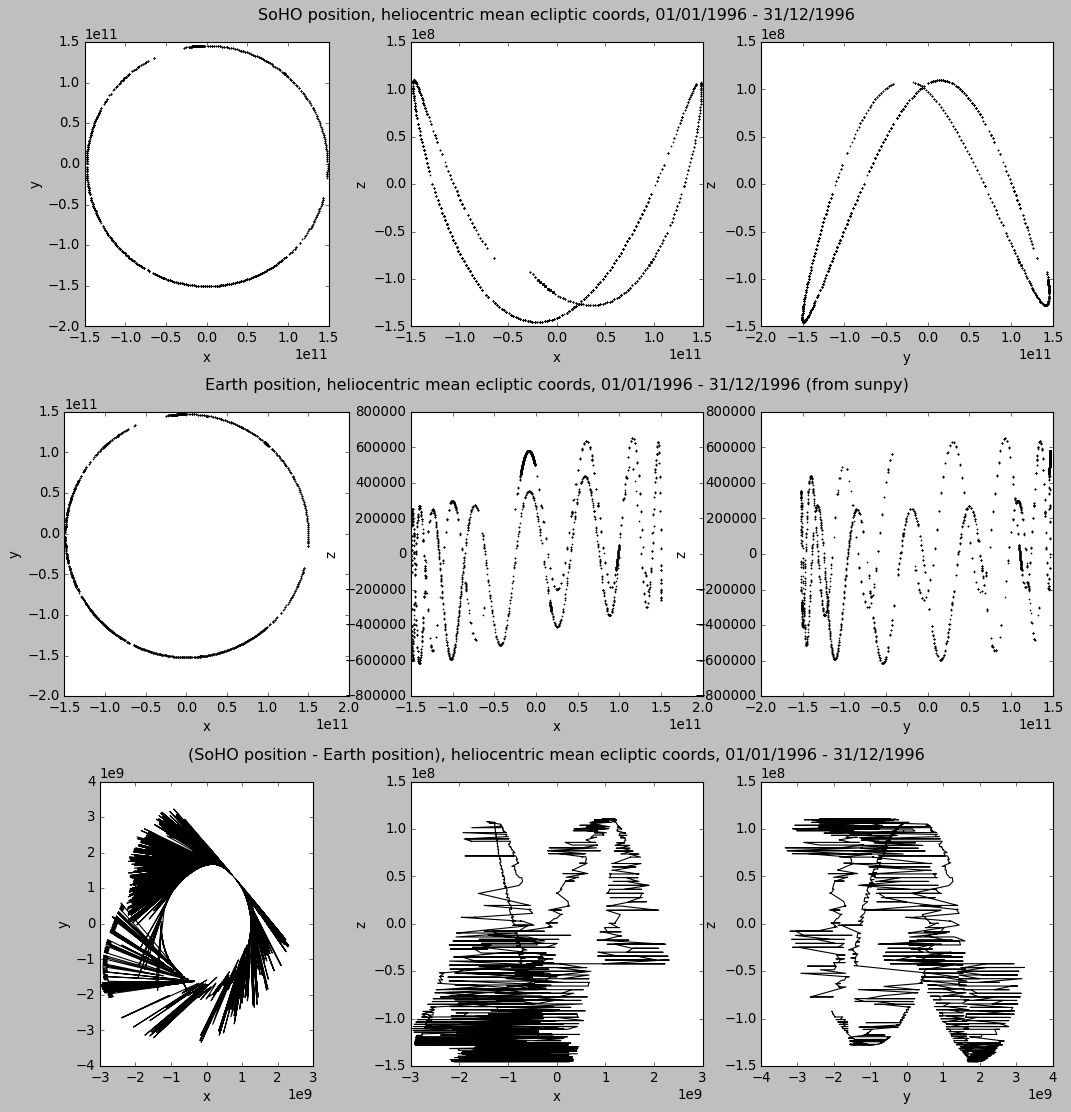

In [15]:
tmask = (EITmetadata['DATE-AVG'] >= jan1_1996) &  (EITmetadata['DATE-AVG'] < jan1_1997)

fig, axes = plt.subplots(3,3,figsize=(16,16))

axes[0,1].set_title("SoHO position, heliocentric mean ecliptic coords, 01/01/1996 - 31/12/1996",pad=20)
axes[0,0].plot(HAEcoords.x[tmask], HAEcoords.y[tmask], 'k.',ms=2,alpha=1)
axes[0,1].plot(HAEcoords.x[tmask], HAEcoords.z[tmask], 'k.',ms=2,alpha=1)
axes[0,2].plot(HAEcoords.y[tmask], HAEcoords.z[tmask], 'k.',ms=2,alpha=1)

axes[1,1].set_title("Earth position, heliocentric mean ecliptic coords, 01/01/1996 - 31/12/1996 (from sunpy)",pad=20)
axes[1,0].plot(earthHAEcoords.x.to(u.m)[tmask], earthHAEcoords.y.to(u.m)[tmask], 'k.',ms=2,alpha=1)
axes[1,1].plot(earthHAEcoords.x.to(u.m)[tmask], earthHAEcoords.z.to(u.m)[tmask], 'k.',ms=2,alpha=1)
axes[1,2].plot(earthHAEcoords.y.to(u.m)[tmask], earthHAEcoords.z.to(u.m)[tmask], 'k.',ms=2,alpha=1)
"""

axes[2,0].set_title("astropy Earth position 01/01/1996 - 31/12/1996")
axes[2,0].plot(earthAstropyHAE.x.to(u.m)[tmask], earthAstropyHAE.y.to(u.m)[tmask], 'k.',ms=2,alpha=1)
axes[2,1].plot(earthAstropyHAE.x.to(u.m)[tmask], earthAstropyHAE.z.to(u.m)[tmask], 'k.',ms=2,alpha=1)
axes[2,2].plot(earthAstropyHAE.y.to(u.m)[tmask], earthAstropyHAE.z.to(u.m)[tmask], 'k.',ms=2,alpha=1)

axes[3,0].set_title("sunpy - astropy Earth position 01/01/1996 - 31/12/1996")
axes[3,0].plot(earthHAEcoords.x.to(u.m)[tmask] - earthAstropyHAE.x.to(u.m)[tmask], earthHAEcoords.y.to(u.m)[tmask] - earthAstropyHAE.y.to(u.m)[tmask], 'k.',ms=2,alpha=1)
axes[3,1].plot(earthHAEcoords.x.to(u.m)[tmask] - earthAstropyHAE.x.to(u.m)[tmask], earthHAEcoords.z.to(u.m)[tmask] - earthAstropyHAE.z.to(u.m)[tmask], 'k.',ms=2,alpha=1)
axes[3,2].plot(earthHAEcoords.y.to(u.m)[tmask] - earthAstropyHAE.y.to(u.m)[tmask], earthHAEcoords.z.to(u.m)[tmask] - earthAstropyHAE.z.to(u.m)[tmask], 'k.',ms=2,alpha=1)
"""

axes[2,1].set_title("(SoHO position - Earth position), heliocentric mean ecliptic coords, 01/01/1996 - 31/12/1996",pad=20)
axes[2,0].plot(HAEcoords.x[tmask] - earthHAEcoords.x.to(u.m)[tmask], HAEcoords.y[tmask] - earthHAEcoords.y.to(u.m)[tmask], 'k-',ms=2,alpha=1)
axes[2,1].plot(HAEcoords.x[tmask] - earthHAEcoords.x.to(u.m)[tmask], HAEcoords.z[tmask] - earthHAEcoords.z.to(u.m)[tmask], 'k-',ms=2,alpha=1)
axes[2,2].plot(HAEcoords.y[tmask] - earthHAEcoords.y.to(u.m)[tmask], HAEcoords.z[tmask] - earthHAEcoords.z.to(u.m)[tmask], 'k-',ms=2,alpha=1)

for ax in axes[:,0]:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

for ax in axes[:,1]:
    ax.set_xlabel("x")
    ax.set_ylabel("z")

for ax in axes[:,2]:
    ax.set_xlabel("y")
    ax.set_ylabel("z")

axes[0,0].set_aspect("equal")
axes[1,0].set_aspect("equal")
axes[2,0].set_aspect("equal")

plt.subplots_adjust(hspace=0.3)
plt.show()
#plt.savefig("./SoHOposition.pdf",bbox_inches="tight")

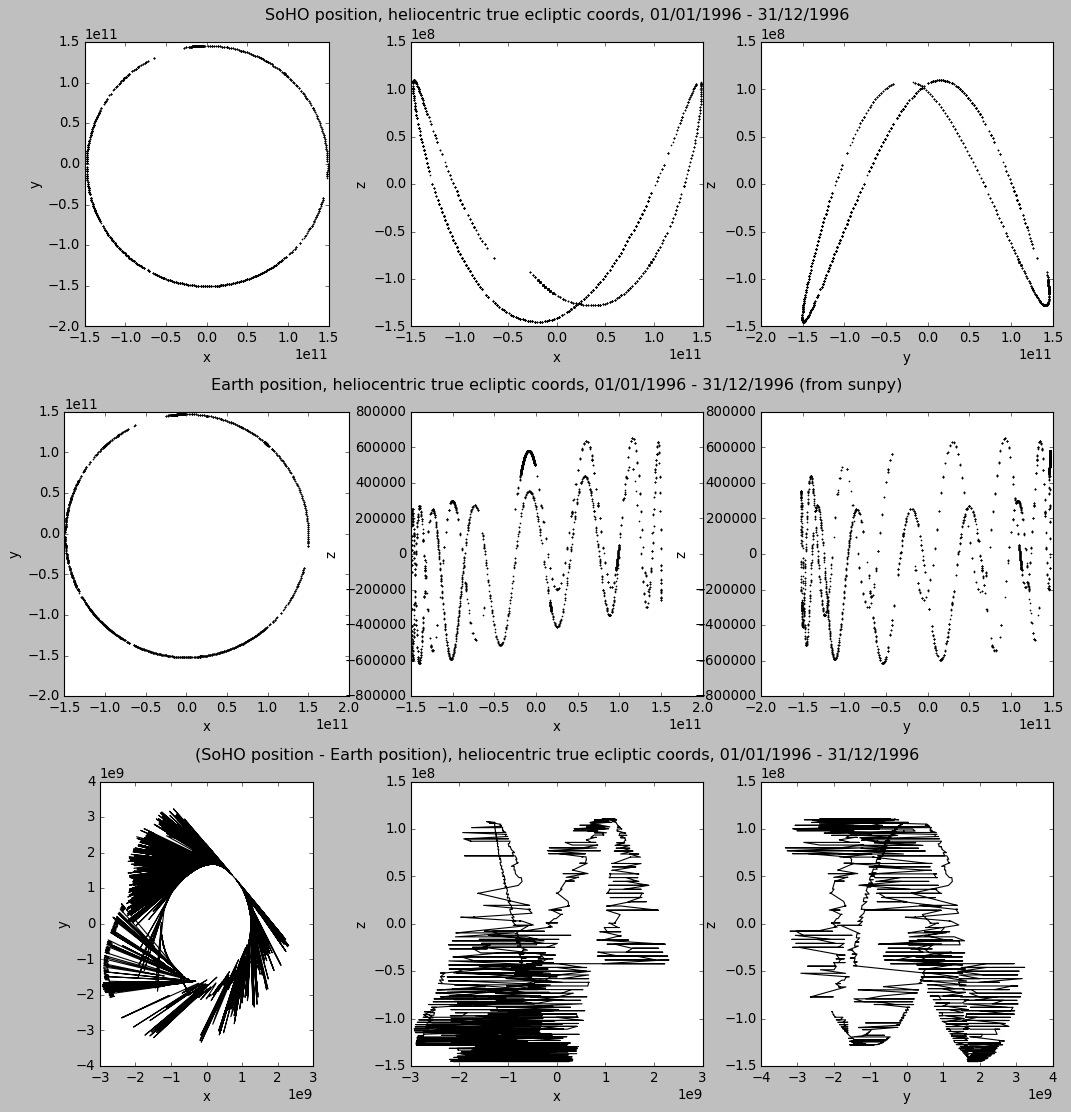

In [16]:
tmask = (EITmetadata['DATE-AVG'] >= jan1_1996) &  (EITmetadata['DATE-AVG'] < jan1_1997)

fig, axes = plt.subplots(3,3,figsize=(16,16))

axes[0,1].set_title("SoHO position, heliocentric true ecliptic coords, 01/01/1996 - 31/12/1996",pad=20)
axes[0,0].plot(HTEcoords.x[tmask], HTEcoords.y[tmask], 'k.',ms=2,alpha=1)
axes[0,1].plot(HTEcoords.x[tmask], HTEcoords.z[tmask], 'k.',ms=2,alpha=1)
axes[0,2].plot(HTEcoords.y[tmask], HTEcoords.z[tmask], 'k.',ms=2,alpha=1)

axes[1,1].set_title("Earth position, heliocentric true ecliptic coords, 01/01/1996 - 31/12/1996 (from sunpy)",pad=20)
axes[1,0].plot(earthHTEcoords.x.to(u.m)[tmask], earthHTEcoords.y.to(u.m)[tmask], 'k.',ms=2,alpha=1)
axes[1,1].plot(earthHTEcoords.x.to(u.m)[tmask], earthHTEcoords.z.to(u.m)[tmask], 'k.',ms=2,alpha=1)
axes[1,2].plot(earthHTEcoords.y.to(u.m)[tmask], earthHTEcoords.z.to(u.m)[tmask], 'k.',ms=2,alpha=1)

axes[2,1].set_title("(SoHO position - Earth position), heliocentric true ecliptic coords, 01/01/1996 - 31/12/1996",pad=20)
axes[2,0].plot(HTEcoords.x[tmask] - earthHTEcoords.x.to(u.m)[tmask], HTEcoords.y[tmask] - earthHTEcoords.y.to(u.m)[tmask], 'k-',ms=2,alpha=1)
axes[2,1].plot(HTEcoords.x[tmask] - earthHTEcoords.x.to(u.m)[tmask], HTEcoords.z[tmask] - earthHTEcoords.z.to(u.m)[tmask], 'k-',ms=2,alpha=1)
axes[2,2].plot(HTEcoords.y[tmask] - earthHTEcoords.y.to(u.m)[tmask], HTEcoords.z[tmask] - earthHTEcoords.z.to(u.m)[tmask], 'k-',ms=2,alpha=1)

for ax in axes[:,0]:
    ax.set_xlabel("x")
    ax.set_ylabel("y")

for ax in axes[:,1]:
    ax.set_xlabel("x")
    ax.set_ylabel("z")

for ax in axes[:,2]:
    ax.set_xlabel("y")
    ax.set_ylabel("z")

axes[0,0].set_aspect("equal")
axes[1,0].set_aspect("equal")
axes[2,0].set_aspect("equal")

plt.subplots_adjust(hspace=0.3)
plt.show()
#plt.savefig("./SoHOposition.pdf",bbox_inches="tight")

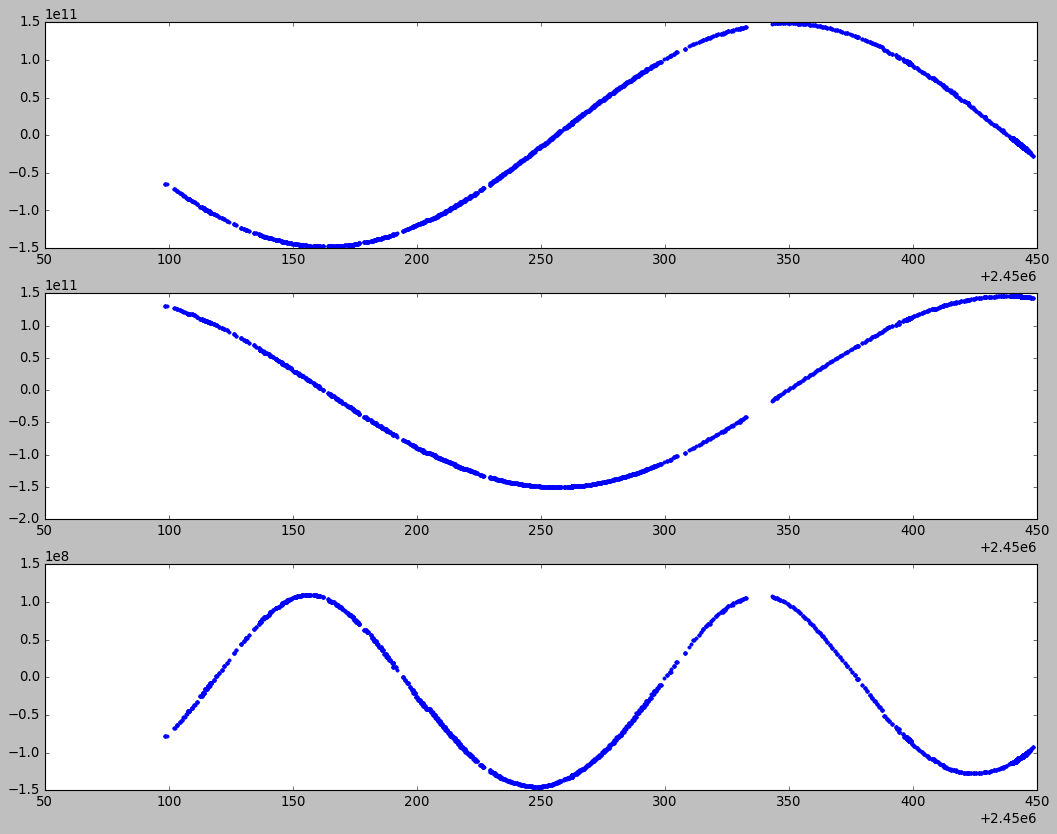

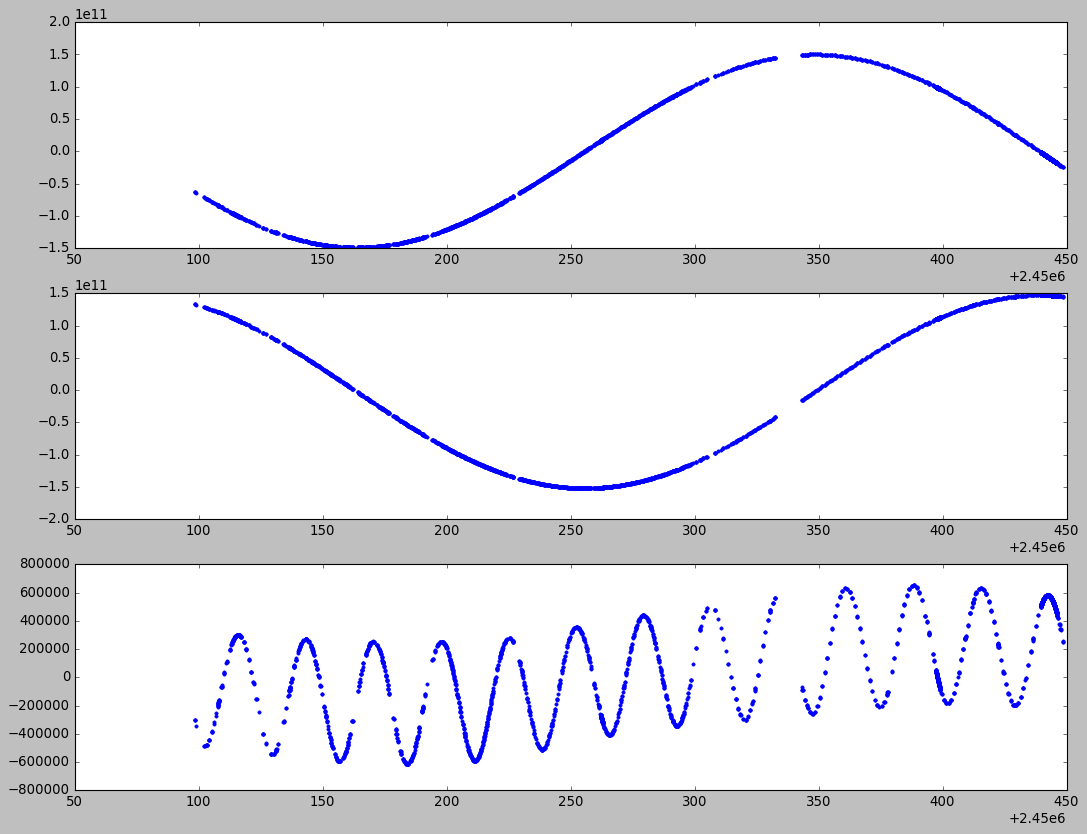

In [17]:
fig, axes = plt.subplots(3,1,figsize=(16,12))
axes[0].plot(EITmetadata['DATE-AVG'][tmask],HAEcoords.x[tmask],'b.')
axes[1].plot(EITmetadata['DATE-AVG'][tmask],HAEcoords.y[tmask],'b.')
axes[2].plot(EITmetadata['DATE-AVG'][tmask],HAEcoords.z[tmask],'b.')
plt.show()

fig, axes = plt.subplots(3,1,figsize=(16,12))
axes[0].plot(EITmetadata['DATE-AVG'][tmask],earthHAEcoords.x.to(u.m)[tmask],'b.')
axes[1].plot(EITmetadata['DATE-AVG'][tmask],earthHAEcoords.y.to(u.m)[tmask],'b.')
axes[2].plot(EITmetadata['DATE-AVG'][tmask],earthHAEcoords.z.to(u.m)[tmask],'b.')
plt.show()

# Plot light curve value against HI latitude

In [18]:
darkImgData =np.loadtxt("./EIT/darkImgFluxes_nobakeout.txt")
print(np.shape(darkImgData))

results = np.genfromtxt("./EIT/EITresults/EIT_LC_withflags.txt")
print(np.shape(results))

print(np.shape(EITmetadata))

(2463, 3)
(91883, 7)
(91883,)


In [19]:
medDist = np.median(results[:,1])*u.m
print(medDist)
print(medDist.to(u.AU))

AUinm = (u.AU.to(u.m))
print(AUinm)

# restrict to after commissioning was completed on Apr 16, 1996
postCommissioningMask = (results[:,0] >= 2450190.)
results = results[postCommissioningMask]
EITmetadata = EITmetadata[postCommissioningMask]

print(np.shape(results))
print(np.shape(EITmetadata))

ts = results[:,0]                               # average date of observation
dists = results[:,1]                            # heliocentric distance in meters
ws = results[:,2].astype(float)                 # wavelength of observation
fs = results[:,3] * (dists/AUinm)               # normalize flux to heliocentric distance of 1AU
us = results[:,4] * (dists/AUinm)               # normalize flux uncertainty to heliocentric distance of 1AU
ps = results[:,5]                               # pinhole flag (==1 if Yes; can only ==1 if the Al_+1 filter was not used)
ces = results[:,6]                              # cameraError flag (==1 if Yes; still not clear exactly what this means)

m171 = (ws == 171.) 
m195 = (ws == 195.) 
m284 = (ws == 284.) 
m304 = (ws == 304.) 
wmasks = [m304,m284,m195,m171]

noPinholes = (ps == 0)
noCameraErrors = (ces == 0)


148114320263.0 m
0.9900830778535941 AU
149597870700.0
(91246, 7)
(91246,)


In [20]:
bakeoutDates = Table.read("./EIT/EITbakeoutDates.txt", format="ascii.basic")
bakeoutDates['jd'] = 0.

for i in range(len(bakeoutDates)):
    date = str(bakeoutDates['date_beg'][i])
    time = str(bakeoutDates['time_beg'][i]).zfill(5)

    y = int(date.split("/")[0])
    m = int(date.split("/")[1])
    d = int(date.split("/")[2])

    h = int(time.split(":")[0])
    min = int(time.split(":")[1])
    
    bakeoutDates[i]['jd'] = np.round(astropy.time.Time({'year':y, 'month':m, 'day':d, 'hour':h, 'minute':min}).jd,3)
    

heaterOnMask = (bakeoutDates['status'] == 'heaterOn')
heaterOffMask = (bakeoutDates['status'] == 'heaterOff')

heaterOn = bakeoutDates[heaterOnMask]
heaterOff = bakeoutDates[heaterOffMask]
print(heaterOn)
print(heaterOff)

 status   date_beg  time_beg dur[h]      jd    
-------- ---------- -------- ------ -----------
heaterOn 1996/05/23    19:21   45.0 2450227.306
heaterOn 1996/06/23    19:10   24.0 2450258.299
heaterOn 1996/07/23    15:48    2.5 2450288.158
heaterOn 1996/08/05    18:50   15.0 2450301.285
heaterOn 1996/08/09    15:05   71.5 2450305.128
heaterOn 1996/09/06    19:49  236.0 2450333.326
heaterOn 1996/12/19    13:14    2.5 2450437.051
heaterOn  1997/01/3    21:50  156.0  2450452.41
heaterOn 1997/02/20    21:57   13.0 2450500.415
heaterOn 1997/03/21    14:26   70.5 2450529.101
heaterOn 1997/07/18    13:30  210.0 2450648.062
heaterOn 1997/11/28    23:00   76.0 2450781.458
heaterOn 1998/03/20    16:35   72.4 2450893.191
heaterOn 1998/04/10    22:00   72.0 2450914.417
     ...        ...      ...    ...         ...
heaterOn  2012/07/2    14:30  153.5 2456111.104
heaterOn 2013/06/21    10:20  230.0 2456464.931
heaterOn 2013/12/18    14:00  279.0 2456645.083
heaterOn 2014/06/13    03:05  253.0 2456

In [21]:
# Eliminate all data points that fall within bakeout periods.
withinBakeout = np.zeros_like(ts).astype(bool)

for i in range(81):
    bakeoutStartDate = heaterOn[i]['jd']
    bakeoutEndDate = heaterOff[i]['jd']

    withinBakeoutMask = (ts > bakeoutStartDate) & (ts < bakeoutEndDate)
    withinBakeout[withinBakeoutMask] = True


In [22]:
tSnow = [2450925,
       2451740, 2451858,
       2452005, 2452015, 2452178, 2452218, 2452237, 2452385, 2452941, 
       2453320, 2453388,  
       2454082]
tSnow = np.array(tSnow)

nearSnow = np.zeros_like(ts).astype(bool)

for t in tSnow:
    if t == 2452941:
        nearSnowMask = (ts >= t-5) & (ts <= t+15)
    else:
        nearSnowMask = (ts >= t-5) & (ts <= t+5)
    
    nearSnow[nearSnowMask] = True


In [23]:
# we want to split up the cos(heliocentric latitude) time series into chunks separated by local optima (local min -> heliocentric latitude == 0)
cosLat = np.cos(HIcoords.lat.to(u.rad))
cosLat = cosLat[postCommissioningMask]

In [24]:
firstMin = np.argmin(cosLat[0:1000])
firstMax = np.argmax(cosLat[0:1500])
print(firstMin)
print

lastMin = np.argmin(cosLat[-1000:]) + len(EITmetadata) - 1000
lastMax = np.argmax(cosLat[-1000:]) + len(EITmetadata) - 1000


timeIntervalIdx = firstMax - firstMin
timeInterval = EITmetadata['DATE-AVG'][firstMax] - EITmetadata['DATE-AVG'][firstMin]
timeIntervalEnd = EITmetadata['DATE-AVG'][lastMax] - EITmetadata['DATE-AVG'][lastMin]

optimaTimes = np.arange(EITmetadata['DATE-AVG'][firstMin], EITmetadata['DATE-AVG'][lastMax], timeIntervalEnd)
print(timeInterval)
print(timeIntervalEnd)
#constructed_local_minima_time = np.arange(

print(len(optimaTimes))

999
-65.70333606470376
90.50009247660637
107


In [25]:
minTimes = []
maxTimes = []

tTest = EITmetadata['DATE-AVG'][0]
print(tTest)

while tTest < EITmetadata['DATE-AVG'][-1]: 
    tMask = (np.abs(EITmetadata['DATE-AVG'] - tTest) < 100.)

    minIdx = np.argmin(cosLat[tMask])
    maxIdx = np.argmax(cosLat[tMask])
    
    tMin = EITmetadata['DATE-AVG'][tMask][minIdx]
    tMax = EITmetadata['DATE-AVG'][tMask][maxIdx]
    if cosLat[tMask][minIdx] < np.cos((7.1*(np.pi/180.))):
        minTimes.append(tMin)
    if cosLat[tMask][maxIdx] > np.cos((0.1*(np.pi/180.))):
        maxTimes.append(tMax)
    """
    fig, ax = plt.subplots(1,1,figsize=(8,6))
    ax.plot(EITmetadata['DATE-AVG'][tMask], cosLat[tMask],'k.')
    ax.axvline(tMin, color='r',lw=2)
    plt.show()
    plt.close()
    """
    tTest = tTest + 150.

optTimes = minTimes + maxTimes
optTimes = np.array(optTimes)
optTimes = np.unique(optTimes)

minTimes = np.array(minTimes)
maxTimes = np.array(maxTimes)

minTimes = np.unique(minTimes)
maxTimes = np.unique(maxTimes)

2450190.404096204


In [26]:
optTimes_infill = []

for i in range(len(optTimes)-1):
    optTimes_infill.append(optTimes[i])
    if optTimes[i+1] - optTimes[i] > 100.:
        optTimes_infill.append(optTimes[i] + ((optTimes[i+1] - optTimes[i])/2.))

optTimes_infill.append(EITmetadata['DATE-AVG'][lastMax])
optTimes_infill = np.array(optTimes_infill)
print(optTimes_infill[1:] - optTimes_infill[0:-1])

[ 90.07087128  91.02779501  90.76854028  91.99197685  92.94368606
  90.30002288  89.68211735  92.07805565  92.50040644  92.50040644
  89.99738231  90.23721308  91.99743311  91.76233483  91.00255111
  89.23656689  94.76263098  90.23820718  89.76347042  91.23676774
  94.76301494  90.00005843  90.99652278  89.24052088  92.99999693
  91.76364163  90.00000065  90.99579565  95.04578565  89.19367653
  89.7638881   92.00062019  92.23435005  91.76562958  89.99565824
  89.24029142  88.99922331  89.50536415  89.50536415 100.44118756
 100.44118756  88.47841784  88.47841784  85.91516516  94.48605664
  90.51317169  87.98594435  92.5012331   94.26231546  90.50050309
  87.77695353  92.96022037  94.24997426  90.24964056  87.83006529
  92.93166501  94.0018444   90.48676535  87.4992964   93.81396727
  93.6993774   89.99909977  87.98782671  93.50870284  93.99163529
  89.51389544  87.99972764  93.49792049  93.98755464  90.00112522
  88.01335676  93.48632336  93.01249333  90.48745424  88.99928132
  93.00684

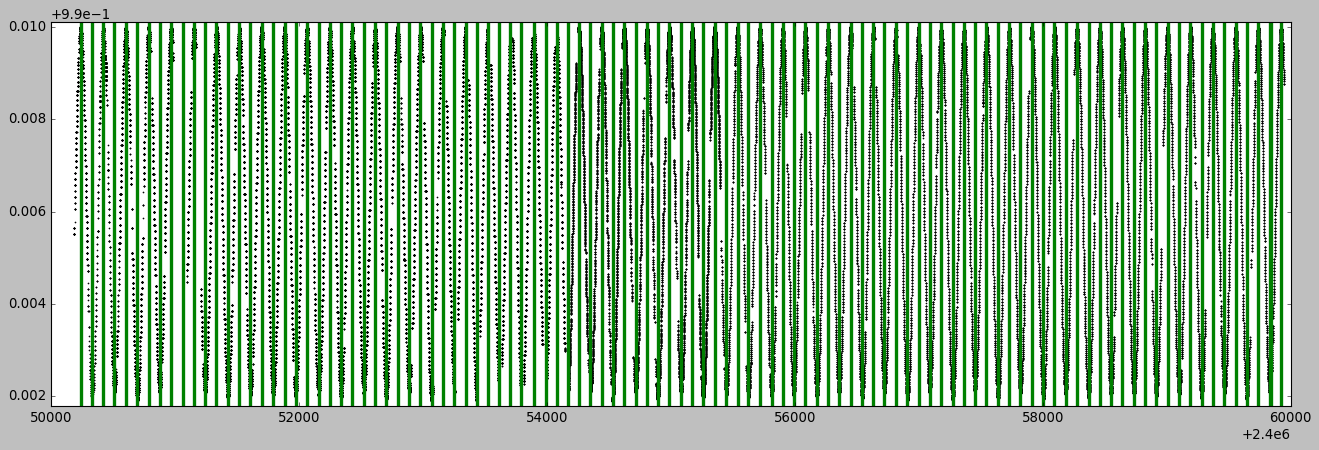

In [27]:
fig, ax = plt.subplots(1,1,figsize=(20,6))
ax.plot(EITmetadata['DATE-AVG'], cosLat, 'k.',ms=2)

for t in optTimes_infill:
    ax.axvline(t, color='g',lw=3)

ax.set_ylim(np.cos((7.35*np.pi/180.)),1.0001)
plt.show()

/Users/Emily/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Emily/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


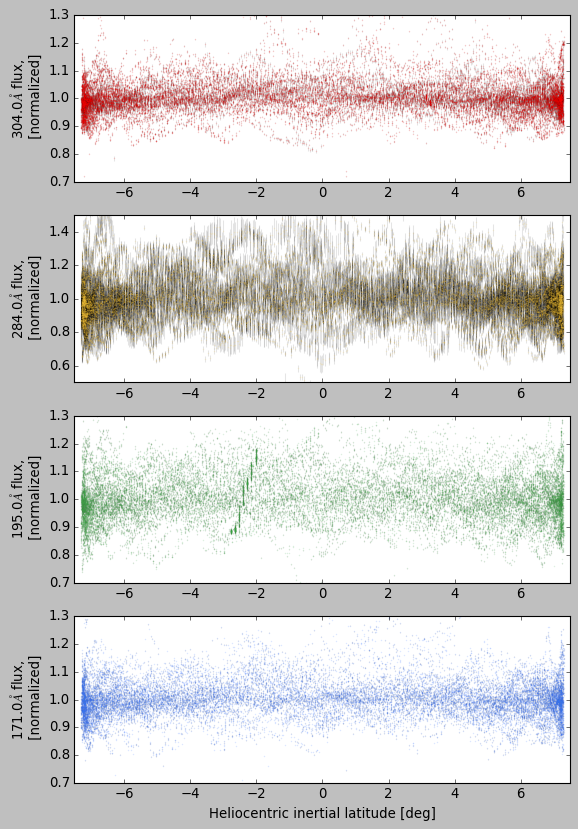

In [28]:
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
fig, axes = plt.subplots(4,1,figsize=(8,12))

for i,ax in enumerate(axes):
    plotcolor = cs[i]
    wmask = wmasks[i] & noPinholes & ~withinBakeout & ~nearSnow

    for j in range(len(optTimes_infill) - 1):
    #for j in np.arange(0,len(optTimes_infill)-1, 2):
        #tMask = (EITmetadata['DATE-AVG'] > optTimes_infill[j]) & (EITmetadata['DATE-AVG'] <= optTimes_infill[j+2])
        tMask = (EITmetadata['DATE-AVG'] > optTimes_infill[j]) & (EITmetadata['DATE-AVG'] <= optTimes_infill[j+1])

        overallMask = wmask & tMask

        fluxnorm = np.median(fs[overallMask][~np.isnan(fs[overallMask])])

        #axes[i].errorbar(np.cos(HIcoords.lat.to(u.rad))[overallMask], fs[overallMask]/fluxnorm, yerr=us[overallMask]/fluxnorm, ls='None', elinewidth=1, capsize=0, marker='.',ms=2,c=plotcolor,ecolor='k')
        axes[i].errorbar(HIcoords.lat[postCommissioningMask][overallMask], fs[overallMask]/fluxnorm, yerr=us[overallMask]/fluxnorm, ls='None', elinewidth=1, capsize=0, marker='.',ms=2,c=plotcolor,ecolor='k',alpha=0.1)
    
    axes[i].set_ylabel(r"{0}$\AA$ flux,""\n"" [normalized]".format(ws[wmask][0]))

    
    #axes[i].set_xlim(np.cos((7.35*np.pi/180.)),1.0001)
    axes[i].set_xlim(-7.5,7.5)
axes[0].set_ylim(0.7,1.3)
axes[1].set_ylim(0.5,1.5)
axes[2].set_ylim(0.7,1.3)
axes[3].set_ylim(0.7,1.3)

#axes[3].set_xlabel("cos(Heliocentric inertial latitude)")
axes[3].set_xlabel("Heliocentric inertial latitude [deg]")
#plt.show()
plt.savefig("./SOHO_flux_vs_heliocentricLat_halfNorm.pdf")

## Bin the above data and plot again 

In [29]:
latLists = [[], [], [], []]
fluxnormLists = [[], [], [], []]

for i in range(4):
    wmask = wmasks[i] & noPinholes & ~withinBakeout & ~nearSnow

    for j in np.arange(0,len(optTimes_infill)-1):
    #for j in np.arange(0,len(optTimes_infill)-1, 2):
        #tMask = (EITmetadata['DATE-AVG'] > optTimes_infill[j]) & (EITmetadata['DATE-AVG'] <= optTimes_infill[j+2])
        tMask = (EITmetadata['DATE-AVG'] > optTimes_infill[j]) & (EITmetadata['DATE-AVG'] <= optTimes_infill[j+1])

        overallMask = wmask & tMask

        fluxnorm = np.median(fs[overallMask][~np.isnan(fs[overallMask])])

        lat_ = HIcoords.lat[postCommissioningMask][overallMask].value
        fluxnorm_ = fs[overallMask]/fluxnorm

        latLists[i].extend(lat_)
        fluxnormLists[i].extend(fluxnorm_)


for i in range(4):
    latLists[i] = np.array((latLists[i]))
    fluxnormLists[i] = np.array((fluxnormLists[i]))

    fluxnormLists[i] = fluxnormLists[i][np.argsort(latLists[i])]
    latLists[i] = latLists[i][np.argsort(latLists[i])]

    latLists[i] = latLists[i][~np.isnan(fluxnormLists[i])]
    fluxnormLists[i] = fluxnormLists[i][~np.isnan(fluxnormLists[i])]

/Users/Emily/anaconda3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/Emily/anaconda3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [30]:
# note that flux in these arrays is normalized over each "sweep" of a solar hemisphere, i.e. scan from pole to equator or vice versa
toSave_304 = np.vstack((latLists[0].T, fluxnormLists[0].T)).T
np.savetxt("./heliocentricLat_304.txt",toSave_304,header='heliocentricLat[deg] normalizedFlux[unitless]')

toSave_284 = np.vstack((latLists[1].T, fluxnormLists[1].T)).T
np.savetxt("./heliocentricLat_284.txt",toSave_284,header='heliocentricLat[deg] normalizedFlux[unitless]')

toSave_195 = np.vstack((latLists[2].T, fluxnormLists[2].T)).T
np.savetxt("./heliocentricLat_195.txt",toSave_195,header='heliocentricLat[deg] normalizedFlux[unitless]')

toSave_171 = np.vstack((latLists[3].T, fluxnormLists[3].T)).T
np.savetxt("./heliocentricLat_171.txt",toSave_171,header='heliocentricLat[deg] normalizedFlux[unitless]')

In [31]:
print(np.shape(latLists[0]))

(21998,)


In [32]:
def percentile16(x):
    return np.percentile(x,q=16)
def percentile84(x):
    return np.percentile(x,q=84)

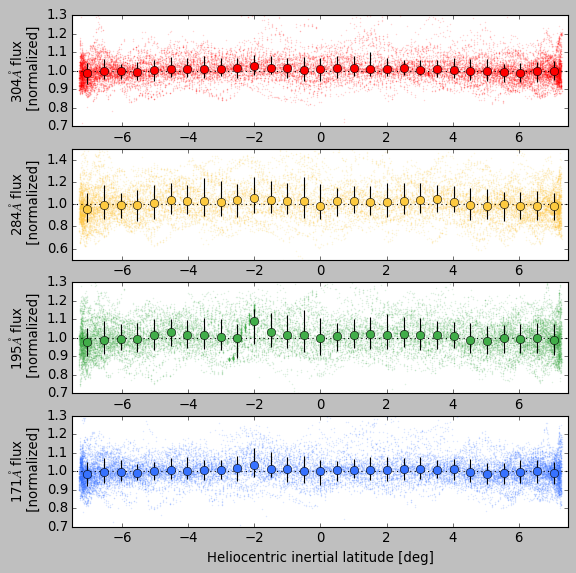

In [33]:
wNames = [304, 284, 195, 171]
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
fig, axes = plt.subplots(4,1,figsize=(8,8))

for i,ax in enumerate(axes):
    plotcolor = cs[i]
    axes[i].plot(latLists[i], fluxnormLists[i], ls='None', marker='.',ms=2,c=plotcolor,alpha=0.1,zorder=1)
    
    binEdges = np.linspace(-7.3, 7.3,30)

    fluxnorm_50 = binned_statistic(latLists[i], fluxnormLists[i], statistic='median',bins = binEdges)[0]
    fluxnorm_16 = binned_statistic(latLists[i], fluxnormLists[i], statistic=percentile16,bins = binEdges)[0]
    fluxnorm_84 = binned_statistic(latLists[i], fluxnormLists[i], statistic=percentile84,bins = binEdges)[0]

    le = fluxnorm_50 - fluxnorm_16
    ue = fluxnorm_84 - fluxnorm_50
    err2d  = np.vstack((le,ue))

    binCenters = (binEdges[0:-1] + binEdges[1:])/2.
    axes[i].errorbar(binCenters, fluxnorm_50, yerr=err2d, ls='None', elinewidth=1, capsize=0, marker='.',ms=15,markeredgecolor='k',c=plotcolor,ecolor='k',alpha=1,zorder=3) 
        
    axes[i].set_ylabel(r"{0}$\AA$ flux""\n"" [normalized]".format(wNames[i]))
    axes[i].set_xlim(-7.5,7.5)
    axes[i].axhline(1.0,color='k',ls=':',zorder=2)
    
axes[0].set_ylim(0.7,1.3)
axes[1].set_ylim(0.5,1.5)
axes[2].set_ylim(0.7,1.3)
axes[3].set_ylim(0.7,1.3)

#axes[3].set_xlabel("cos(Heliocentric inertial latitude)")
axes[3].set_xlabel("Heliocentric inertial latitude [deg]")
#plt.show()
plt.savefig("./SOHO_flux_vs_heliocentricLat_binned_halfNorm.pdf")

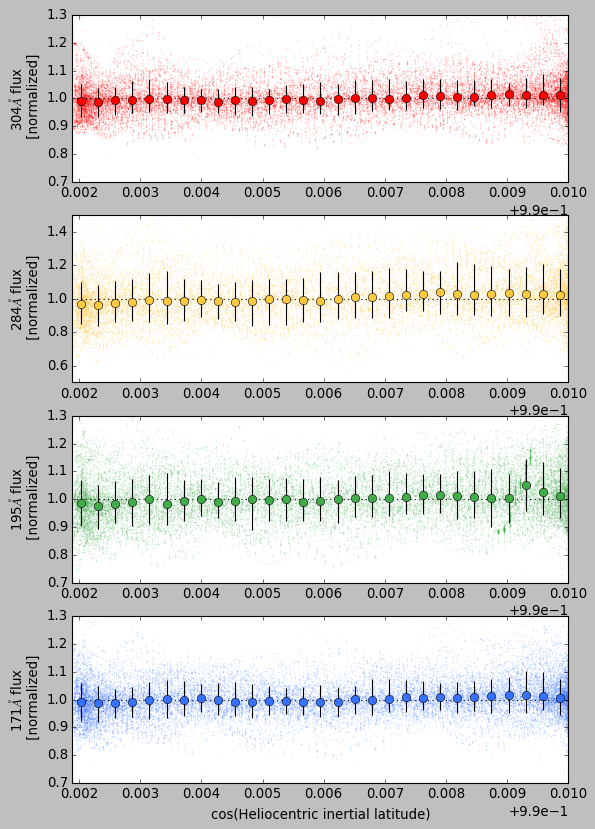

In [34]:
wNames = [304, 284, 195, 171]
cs = ['r', '#fdca40', '#41ad49', '#3772ff']
fig, axes = plt.subplots(4,1,figsize=(8,12))

for i,ax in enumerate(axes):
    plotcolor = cs[i]
    axes[i].plot(np.cos(latLists[i]*(np.pi/180.)), fluxnormLists[i], ls='None', marker='.',ms=2,c=plotcolor,alpha=0.1,zorder=1)
    
    binEdges = np.linspace(np.min(np.cos(latLists[i]*(np.pi/180.))), 1.,30)

    fluxnorm_50 = binned_statistic(np.cos(latLists[i]*(np.pi/180.)), fluxnormLists[i], statistic='median',bins = binEdges)[0]
    fluxnorm_16 = binned_statistic(np.cos(latLists[i]*(np.pi/180.)), fluxnormLists[i], statistic=percentile16,bins = binEdges)[0]
    fluxnorm_84 = binned_statistic(np.cos(latLists[i]*(np.pi/180.)), fluxnormLists[i], statistic=percentile84,bins = binEdges)[0]

    le = fluxnorm_50 - fluxnorm_16
    ue = fluxnorm_84 - fluxnorm_50
    err2d  = np.vstack((le,ue))

    binCenters = (binEdges[0:-1] + binEdges[1:])/2.
    axes[i].errorbar(binCenters, fluxnorm_50, yerr=err2d, ls='None', elinewidth=1, capsize=0, marker='.',ms=15,markeredgecolor='k',c=plotcolor,ecolor='k',alpha=1,zorder=3) 
        
    axes[i].set_ylabel(r"{0}$\AA$ flux""\n"" [normalized]".format(wNames[i]))
    axes[i].set_xlim(np.min(np.cos(latLists[i]*(np.pi/180.))), 1.)
    axes[i].axhline(1.0,color='k',ls=':',zorder=2)
    
axes[0].set_ylim(0.7,1.3)
axes[1].set_ylim(0.5,1.5)
axes[2].set_ylim(0.7,1.3)
axes[3].set_ylim(0.7,1.3)

#axes[3].set_xlabel("cos(Heliocentric inertial latitude)")
axes[3].set_xlabel("cos(Heliocentric inertial latitude)")
#plt.show()
plt.savefig("./SOHO_flux_vs_cosheliocentricLat_binned_halfNorm.pdf")

# Filter keyword

In [173]:
print(set(EITmetadata['FILTER']))

EITmetadata['FILTERFLAG'] = 0

for i in range(len(EITmetadata)):
    if EITmetadata['FILTER'][i] == 'Clear':
        EITmetadata['FILTERFLAG'][i] = 0
    elif EITmetadata['FILTER'][i] == 'Al_sup':
        EITmetadata['FILTERFLAG'][i] = 1
    elif EITmetadata['FILTER'][i] == 'Al_+1':
        EITmetadata['FILTERFLAG'][i] = 2

{'Al_+1', 'Al_sup', 'Clear'}


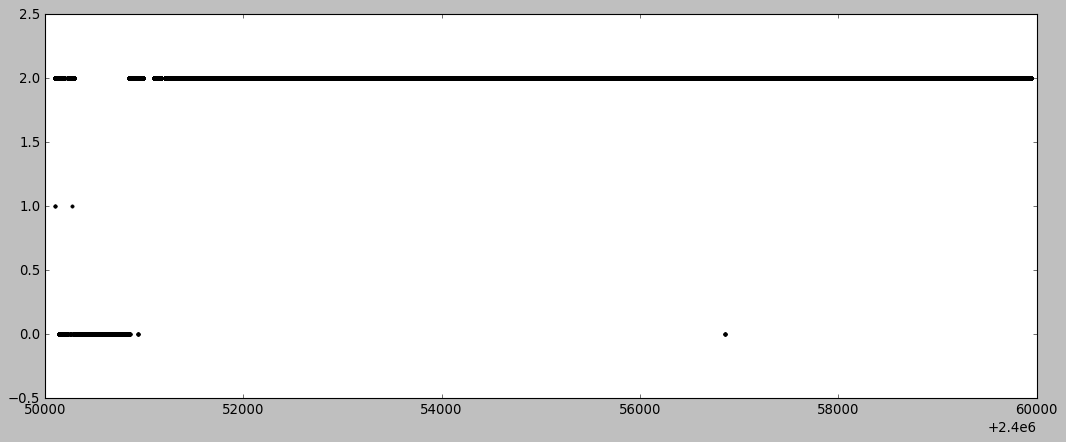

In [175]:
fig, ax = plt.subplots(1,1,figsize=(16,6))
ax.plot(EITmetadata['DATE-AVG'],EITmetadata['FILTERFLAG'],'k.')
ax.set_ylim(-0.5,2.5)
plt.show()

# Parker Solar Probe position

In [28]:
psp_data = Table.read("./parkerSolarProbeLocation.txt",format="ascii.basic")

psp_data['jd'] = 0.

for i in range(len(psp_data)):
    y = psp_data['YEAR'][i]
    if y % 4==0:
        dec_y = psp_data['YEAR'][i] + psp_data['DAY'][i]/366.
    else:
        dec_y = psp_data['YEAR'][i] + psp_data['DAY'][i]/366.

    psp_data[i]['jd'] = astropy.time.Time(dec_y,format="decimalyear",scale='utc').jd

print(psp_data)

YEAR DAY RAD_AU SE_LAT SE_LON         jd        
---- --- ------ ------ ------ ------------------
2018 250   0.94   -1.5  334.7  2458368.816939891
2018 251   0.94   -1.5  335.3 2458369.8142076503
2018 252   0.93   -1.6  336.0 2458370.8114754097
2018 253   0.93   -1.7  336.7 2458371.8087431695
2018 254   0.92   -1.7  337.3  2458372.806010929
2018 255   0.92   -1.8  338.0 2458373.8032786883
2018 256   0.91   -1.8  338.7  2458374.800546448
2018 257    0.9   -1.9  339.4 2458375.7978142076
2018 258    0.9   -2.0  340.1  2458376.795081967
2018 259   0.89   -2.0  340.8  2458377.792349727
2018 260   0.88   -2.1  341.6 2458378.7896174863
2018 261   0.87   -2.2  342.3 2458379.7868852457
 ... ...    ...    ...    ...                ...
2024 354   0.27   -3.2    5.0          2460664.5
2024 355   0.24   -3.1    9.5          2460665.5
2024 356    0.2   -3.0   15.7          2460666.5
2024 357   0.16   -2.7   25.1          2460667.5
2024 358   0.11   -2.0   42.0          2460668.5
2024 359   0.06    0

In [33]:
HIcoords = SkyCoord(frame='heliocentricinertial',lon=psp_data['SE_LON']*u.deg,lat=psp_data['SE_LAT']*u.deg, distance=psp_data['RAD_AU']*u.AU, obstime=astropy.time.Time(psp_data['jd'],format='jd'))
print(HIcoords)

HAEcoords = HIcoords.transform_to(astropy.coordinates.HeliocentricMeanEcliptic())
print(HAEcoords)

<SkyCoord (HeliocentricInertial: obstime=[2458368.81693989 2458369.81420765 2458370.81147541 ... 2460673.5
 2460674.5        2460675.5       ]): (lon, lat, distance) in (deg, deg, AU)
    [(-25.3, -1.5, 0.94), (-24.7, -1.5, 0.94), (-24. , -1.6, 0.93), ...,
     (-84.7, -1.1, 0.2 ), (-78.6, -1.4, 0.24), (-74.1, -1.6, 0.27)]>
<SkyCoord (HeliocentricMeanEcliptic: equinox=J2000.000, obstime=[2458368.81693989 2458369.81420765 2458370.81147541 ... 2460673.5
 2460674.5        2460675.5       ]): (lon, lat, distance) in (deg, deg, AU)
    [( 50.81503458, -4.58247683, 0.94), ( 51.41274821, -4.51364253, 0.94),
     ( 52.1215637 , -4.5322534 , 0.93), ...,
     (351.12129792, -8.32048999, 0.2 ), (357.29081928, -8.50747695, 0.24),
     (  1.84376072, -8.57191285, 0.27)]>


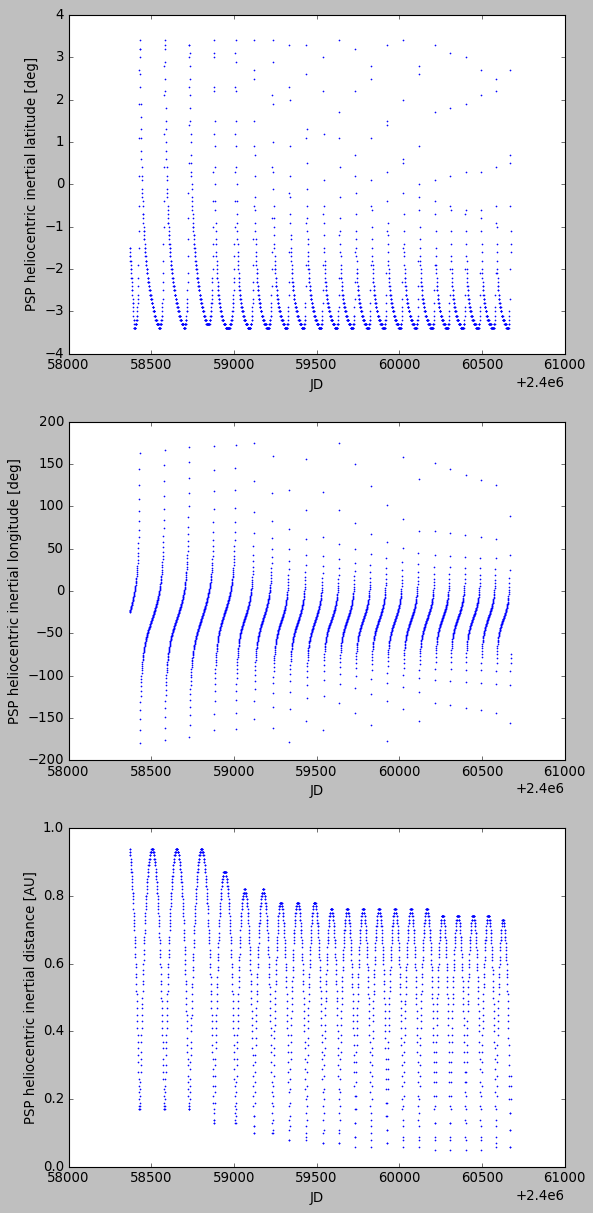

In [30]:
fig, axes = plt.subplots(3,1,figsize=(8,18))
axes[0].plot(psp_data['jd'], HIcoords.lat, 'b.',ls='None',ms=2)
axes[0].set_xlabel("JD")
axes[0].set_ylabel("PSP heliocentric inertial latitude [deg]")

axes[1].plot(psp_data['jd'], HIcoords.lon, 'b.',ls='None',ms=2)
axes[1].set_xlabel("JD")
axes[1].set_ylabel("PSP heliocentric inertial longitude [deg]")

axes[2].plot(psp_data['jd'], HIcoords.distance, 'b.',ls='None',ms=2)
axes[2].set_xlabel("JD")
axes[2].set_ylabel("PSP heliocentric inertial distance [AU]")
plt.show()

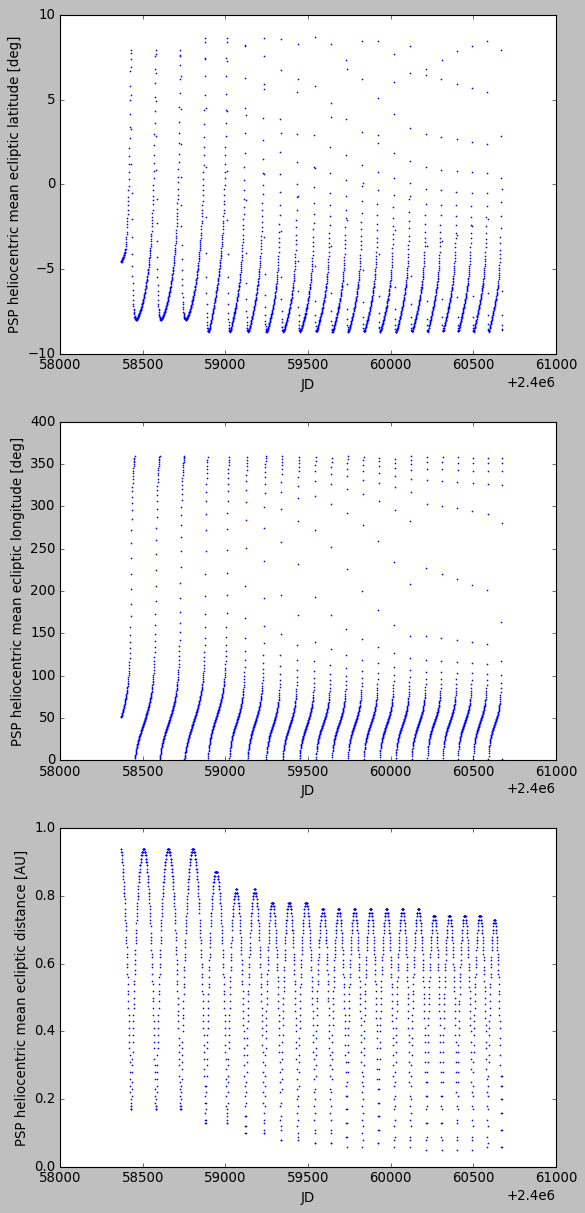

In [34]:
fig, axes = plt.subplots(3,1,figsize=(8,18))
axes[0].plot(psp_data['jd'], HAEcoords.lat, 'b.',ls='None',ms=2)
axes[0].set_xlabel("JD")
axes[0].set_ylabel("PSP heliocentric mean ecliptic latitude [deg]")

axes[1].plot(psp_data['jd'], HAEcoords.lon, 'b.',ls='None',ms=2)
axes[1].set_xlabel("JD")
axes[1].set_ylabel("PSP heliocentric mean ecliptic longitude [deg]")

axes[2].plot(psp_data['jd'], HAEcoords.distance, 'b.',ls='None',ms=2)
axes[2].set_xlabel("JD")
axes[2].set_ylabel("PSP heliocentric mean ecliptic distance [AU]")
plt.show()